# A/B test 4 - loved journeys, control vs LLR

This related links B/C test (ab4) was conducted from 22nd-28th March 2019.

The data used in this report are 23rd-27th Mar 2019 because the test was started partway through 22nd Ma, and ended partway through 28th Mar.

The test compared the existing related links (where available) to links generated using LLR algorithm 

## Import

In [90]:
%load_ext autoreload
%autoreload 2

import os 
import pandas as pd
import numpy as np
import ast
import re

# z test
from statsmodels.stats.proportion import proportions_ztest

# bayesian bootstrap and vis
import matplotlib.pyplot as plt
import seaborn as sns
import bayesian_bootstrap.bootstrap as bb
from astropy.utils import NumpyRNGContext

# progress bar
from tqdm import tqdm, tqdm_notebook

from scipy import stats
from collections import Counter

import sys
sys.path.insert(0, '../../src' )
import analysis as analysis

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [91]:
# set up the style for our plots
sns.set(style='white', palette='colorblind', font_scale=1.3,
        rc={'figure.figsize':(12,9), 
            "axes.facecolor": (0, 0, 0, 0)})

# instantiate progress bar goodness
tqdm.pandas(tqdm_notebook)

pd.set_option('max_colwidth',500)

# the number of bootstrap means used to generate a distribution
boot_reps = 10000

# alpha - false positive rate
alpha = 0.05
# number of tests
m = 4
# Correct alpha for multiple comparisons
alpha = alpha / m

# The Bonferroni correction can be used to adjust confidence intervals also. 
# If one establishes m confidence intervals, and wishes to have an overall confidence level of 1-alpha,
# each individual confidence interval can be adjusted to the level of 1-(alpha/m).

# reproducible
seed = 1337

## File/dir locations
### Processed journey data

In [92]:
DATA_DIR = os.getenv("DATA_DIR")
filename = "full_sample_loved_947858.csv.gz"
filepath = os.path.join(
    DATA_DIR, "sampled_journey", "20190323_20190327",
    filename)
filepath

'/Users/suganyasivaskantharajah/code/govuk_ab_analysis/data/sampled_journey/20190323_20190327/full_sample_loved_947858.csv.gz'

In [93]:
CONTROL_GROUP = "B"
INTERVENTION_GROUP = "C"

VARIANT_DICT = {
    'CONTROL_GROUP':'B',
    'INTERVENTION_GROUP':'C'
}

In [94]:
# read in processed sampled journey with just the cols we need for related links
df = pd.read_csv(filepath, sep ="\t", compression="gzip")
# convert from str to list
df['Event_cat_act_agg']= df['Event_cat_act_agg'].progress_apply(ast.literal_eval)
df['Page_Event_List'] = df['Page_Event_List'].progress_apply(ast.literal_eval)
df['Page_List'] = df['Page_List'].progress_apply(ast.literal_eval)

100%|██████████| 772387/772387 [00:14<00:00, 51676.71it/s]


In [95]:
# drop dodgy rows, where page variant is not A or B.
df = df.query('ABVariant in [@CONTROL_GROUP, @INTERVENTION_GROUP]')

In [96]:
df[['Occurrences', 'ABVariant']].groupby('ABVariant').sum()

,Occurrences
ABVariant,
B,947857
C,947857


In [97]:
df['Page_List_Length'] = df['Page_List'].progress_apply(len)


100%|██████████| 772387/772387 [00:00<00:00, 786616.91it/s]


### Nav type of page lookup - is it a finding page? if not it's a thing page

In [98]:
filename = "document_types.csv.gz"

# created a metadata dir in the DATA_DIR to hold this data
filepath = os.path.join(
    DATA_DIR, "metadata",
    filename)
print(filepath)

df_finding_thing = pd.read_csv(filepath, sep="\t", compression="gzip")

df_finding_thing.head()

/Users/suganyasivaskantharajah/code/govuk_ab_analysis/data/metadata/document_types.csv.gz


,pagePath,is_finding
0,/jobsearch,0
1,/pay-leave-for-parents/y,0
2,/student-finance-calculator/y/2018-2019/uk-full-time,0
3,/government/publications/application-for-confirmation-of-british-nationality-status-form-ns,0
4,/pip/eligibility,0


In [99]:
thing_page_paths = df_finding_thing[
    df_finding_thing['is_finding']==0]['pagePath'].tolist()


finding_page_paths = df_finding_thing[
    df_finding_thing['is_finding']==1]['pagePath'].tolist()

## Outliers
Some rows should be removed before analysis. For example rows with journey lengths of 500 or very high related link click rates. This process might have to happen once features have been created.

# Derive variables

## journey_click_rate
There is no difference in the proportion of journeys using at least one related link (journey_click_rate) between page variant A and page variant B.



\begin{equation*}
\frac{\text{total number of journeys including at least one click on a related link}}{\text{total number of journeys}}
\end{equation*}

In [100]:
# get the number of related links clicks per Sequence
df['Related Links Clicks per seq'] = df['Event_cat_act_agg'].map(analysis.sum_related_click_events)

In [101]:
# map across the Sequence variable, which includes pages and Events
# we want to pass all the list elements to a function one-by-one and then collect the output.
df["Has_Related"] = df["Related Links Clicks per seq"].map(analysis.is_related)

df['Related Links Clicks row total'] = df['Related Links Clicks per seq'] * df['Occurrences']


In [102]:
df.head(3)

,ABVariant,Page_Event_List,Page_List,Event_cat_act_agg,Occurrences,Page_List_Length,Related Links Clicks per seq,Has_Related,Related Links Clicks row total
0,B,"[(/ biometric-residence-permits, PAGE<:<NULL<:<NULL, other), (/government/publications/form-an-guidance, PAGE<:<NULL<:<NULL, other), (/search?q=biometric+residence++card, PAGE<:<NULL<:<NULL, other), (/search?q=biometric+residence++card, EVENT<:<searchResults<:<resultsShown, other), (/search?q=biometric+residence++card, EVENT<:<UX<:<click, other), (/government/publications/eu-settlement-scheme-id-document-scanner-locations, PAGE<:<NULL<:<NULL, d6c2de5d-ef90-45d1-82d4-5f2438369eea), (/search?q...","[/ biometric-residence-permits, /government/publications/form-an-guidance, /search?q=biometric+residence++card, /government/publications/eu-settlement-scheme-id-document-scanner-locations, /search?q=biometric+residence++card, /biometric-residence-permits, /biometric-residence-permits/collect, /search?q=permanent+residence+, /uk-residence-eu-citizens, /uk-residence-eu-citizens/permanent-residence, /apply-citizenship-eea, /british-citizenship, /renounce-british-nationality/resume-your-british-...","[((PAGE_NULL, PAGE_NULL), 25), ((searchResults, resultsShown), 5), ((UX, click), 4), ((contentsClicked, content_item 3), 2), ((contentsClicked, content_item 4), 1), ((External Link Clicked, https://visas-immigration.service.gov.uk/product/eea-pr), 1)]",1,25,0,False,0
1,B,"[(/ browse/driving, PAGE<:<NULL<:<NULL, other), (/ browse/driving, PAGE<:<NULL<:<NULL, other), (/search, PAGE<:<NULL<:<NULL, other), (/search?q=car+tax+rules, PAGE<:<NULL<:<NULL, other), (/search?q=car+tax+rules, EVENT<:<searchResults<:<resultsShown, other), (/search?q=car+tax+rules, EVENT<:<UX<:<click, other), (/calculate-vehicle-tax-rates, PAGE<:<NULL<:<NULL, 1de432b7-2331-4450-9667-374d56e7f084), (/calculate-vehicle-tax-rates, EVENT<:<External Link Clicked<:<https://carfueldata.vehicle-ce...","[/ browse/driving, / browse/driving, /search, /search?q=car+tax+rules, /calculate-vehicle-tax-rates]","[((PAGE_NULL, PAGE_NULL), 5), ((searchResults, resultsShown), 1), ((UX, click), 1), ((External Link Clicked, https://carfueldata.vehicle-certification-agency.gov.uk/new-vehicle-tax.aspx), 1)]",1,5,0,False,0
2,B,"[(/ check, PAGE<:<NULL<:<NULL, other), (/check-vehicle-tax, PAGE<:<NULL<:<NULL, 1de432b7-2331-4450-9667-374d56e7f084), (/check-vehicle-tax, EVENT<:<External Link Clicked<:<https://www.vehicleenquiry.service.gov.uk, 1de432b7-2331-4450-9667-374d56e7f084)]","[/ check, /check-vehicle-tax]","[((PAGE_NULL, PAGE_NULL), 2), ((External Link Clicked, https://www.vehicleenquiry.service.gov.uk), 1)]",1,2,0,False,0


## count of clicks on navigation elements

There is no statistically significant difference in the count of clicks on navigation elements per journey between page variant A and page variant B.

\begin{equation*}
{\text{total number of navigation element click events from content pages}}
\end{equation*}

### Related link counts

In [103]:
# get the total number of related links clicks for that row (clicks per sequence multiplied by occurrences)
df['Related Links Clicks row total'] = df['Related Links Clicks per seq'] * df['Occurrences']

### Navigation events

In [104]:
def count_nav_events(page_event_list):
    """Counts the number of nav events from a content page in a Page Event List."""
    content_page_nav_events = 0
    for pair in page_event_list:
        if analysis.is_nav_event(pair[1]):
            if pair[0] in thing_page_paths:
                content_page_nav_events += 1
    return content_page_nav_events

In [105]:
# needs finding_thing_df read in from document_types.csv.gz
df['Content_Page_Nav_Event_Count'] = df['Page_Event_List'].progress_map(count_nav_events)

100%|██████████| 772387/772387 [17:44<00:00, 725.28it/s]  


In [106]:
def count_search_from_content(page_list):
    search_from_content = 0
    for i, page in enumerate(page_list):
        if i > 0:
            if '/search?q=' in page:
                if page_list[i-1] in thing_page_paths:
                    search_from_content += 1
    return search_from_content

In [107]:
df['Content_Search_Event_Count'] = df['Page_List'].progress_map(count_search_from_content)

100%|██████████| 772387/772387 [16:03:14<00:00, 13.36it/s]       


In [108]:
# count of nav or search clicks
df['Content_Nav_or_Search_Count'] = df['Content_Page_Nav_Event_Count'] + df['Content_Search_Event_Count']
# occurrences is accounted for by the group by bit in our bayesian boot analysis function
df['Content_Nav_Search_Event_Sum_row_total'] = df['Content_Nav_or_Search_Count'] * df['Occurrences']
# required for journeys with no nav later
df['Has_No_Nav_Or_Search'] = df['Content_Nav_Search_Event_Sum_row_total'] == 0

## Temporary df file in case of crash
### Save

In [109]:
df.to_csv(os.path.join(
    DATA_DIR, 
    "ab3_loved_temp.csv.gz"), sep="\t", compression="gzip", index=False)

In [110]:
df = pd.read_csv(os.path.join(
    DATA_DIR, 
    "ab3_loved_temp.csv.gz"), sep="\t", compression="gzip")

### Frequentist statistics

#### Statistical significance

In [112]:
# help(proportions_ztest)

In [113]:
has_rel = analysis.z_prop(df, 'Has_Related', VARIANT_DICT)
has_rel

{'metric_name': 'Has_Related',
 'stats_method': 'z_prop_test',
 'x_ab': 87114,
 'n_ab': 1895714,
 'p': 0.04595313428080396,
 'x_a': 33134,
 'n_a': 947857,
 'p_a': 0.03495674980508663,
 'x_b': 53980,
 'n_b': 947857,
 'p_b': 0.05694951875652129,
 'test_statistic': -72.30925733534379,
 'p-value': 0.0}

In [114]:
has_rel['p-value'] < alpha

True

#### Practical significance - uplift

In [115]:
# Due to multiple testing we used the Bonferroni correction for alpha
ci_low,ci_upp = analysis.zconf_interval_two_samples(has_rel['x_a'], has_rel['n_a'],
                                           has_rel['x_b'], has_rel['n_b'], alpha = alpha)
print(' difference in proportions = {0:.2f}%'.format(100*(has_rel['p_b']-has_rel['p_a'])))
print(' % relative change in proportions = {0:.2f}%'.format(100*((has_rel['p_b']-has_rel['p_a'])/has_rel['p_a'])))
print(' 95% Confidence Interval = ( {0:.2f}% , {1:.2f}% )'
      .format(100*ci_low, 100*ci_upp))

 difference in proportions = 2.20%
 % relative change in proportions = 62.91%
 95% Confidence Interval = ( 2.12% , 2.28% )


### Bayesian statistics 

Based on [this](https://medium.com/@thibalbo/coding-bayesian-ab-tests-in-python-e89356b3f4bd) blog

To be developed, a Bayesian approach can provide a simpler interpretation.

### Bayesian bootstrap

In [116]:
analysis.compare_total_searches(df, VARIANT_DICT)

total searches in control group = 55162
total searches in intervention group = 50942
intervention has 4220 fewer navigation or searches than control;
a 3.98% overall difference
The relative change was -7.65% from control to intervention


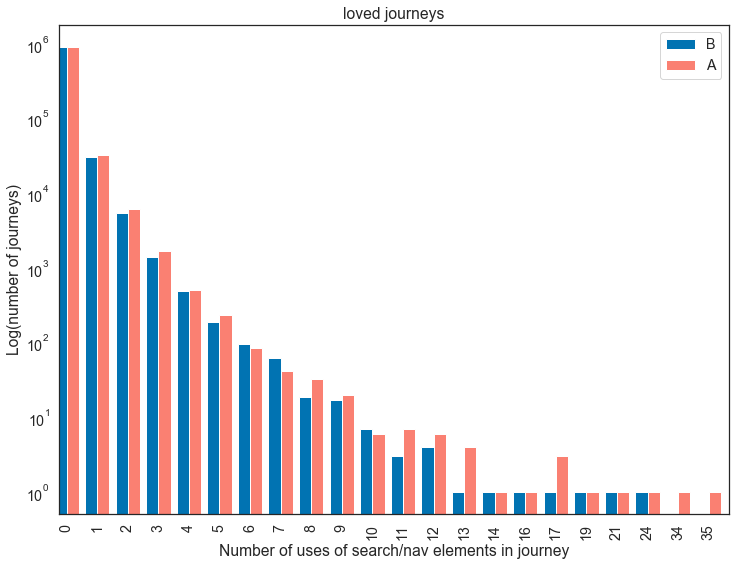

In [117]:
fig, ax = plt.subplots()
plot_df_B = df[df.ABVariant == VARIANT_DICT['INTERVENTION_GROUP']].groupby(
            'Content_Nav_or_Search_Count').sum().iloc[:, 0]
plot_df_A = df[df.ABVariant == VARIANT_DICT['CONTROL_GROUP']].groupby(
            'Content_Nav_or_Search_Count').sum().iloc[:, 0]

ax.set_yscale('log')
width =0.4
ax = plot_df_B.plot.bar(label='B', position=1, width=width)
ax = plot_df_A.plot.bar(label='A', color='salmon', position=0, width=width)
plt.title("loved journeys")
plt.ylabel("Log(number of journeys)")
plt.xlabel("Number of uses of search/nav elements in journey")

legend = plt.legend(frameon=True)
frame = legend.get_frame()
frame.set_facecolor('white')
plt.savefig('nav_counts_loved_bar.png', dpi = 900, bbox_inches = 'tight')

In [118]:
a_bootstrap, b_bootstrap = analysis.bayesian_bootstrap_analysis(df, col_name='Content_Nav_or_Search_Count', boot_reps=boot_reps, seed = seed, variant_dict=VARIANT_DICT)

In [119]:
np.array(a_bootstrap).mean()

0.05820012888507547

In [120]:
np.array(a_bootstrap).mean() - (0.05 * np.array(a_bootstrap).mean())

0.055290122440821696

In [121]:
np.array(b_bootstrap).mean()

0.05374276127119793

In [122]:
print("A relative change of {0:.2f}% from control to intervention".format((np.array(b_bootstrap).mean()-np.array(a_bootstrap).mean())/np.array(a_bootstrap).mean()*100))

A relative change of -7.66% from control to intervention


In [123]:
# ratio is vestigial but we keep it here for convenience
# it's actually a count but considers occurrences
ratio_stats = analysis.bb_hdi(a_bootstrap, b_bootstrap, alpha=alpha)
ratio_stats

{'a_ci_low': 0.057340263792693386,
 'a_ci_hi': 0.05900720171265973,
 'b_ci_low': 0.052945196317475116,
 'b_ci_hi': 0.05451555572227326,
 'diff_mean': -0.004457367613877534,
 'diff_ci_low': -0.005592463803188147,
 'diff_ci_hi': -0.0033604758542099336,
 'prob_b_>_a': 0.0}

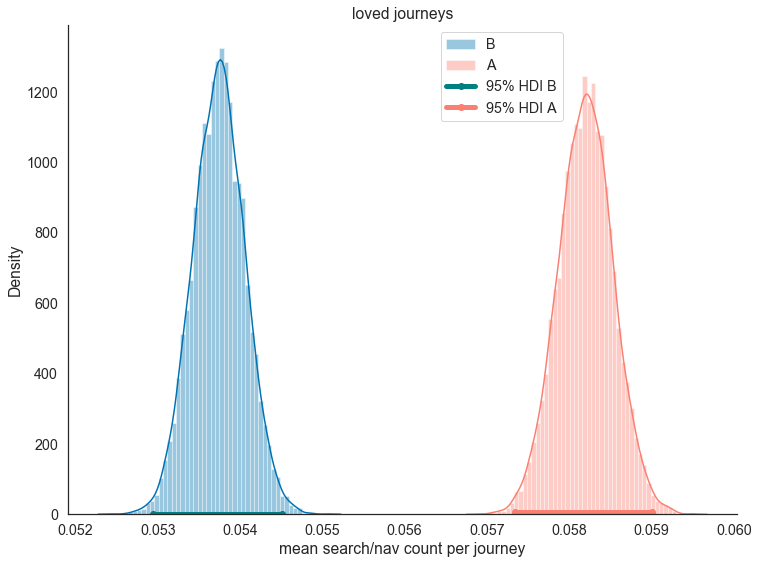

In [124]:
ax = sns.distplot(b_bootstrap, label='B')
ax.errorbar(x=[ratio_stats['b_ci_low'], ratio_stats['b_ci_hi']], y=[2, 2], linewidth=5, c='teal', marker='o', 
         label='95% HDI B')

ax = sns.distplot(a_bootstrap, label='A', ax=ax, color='salmon')
ax.errorbar(x=[ratio_stats['a_ci_low'], ratio_stats['a_ci_hi']], y=[5, 5], linewidth=5, c='salmon', marker='o', 
         label='95% HDI A')

ax.set(xlabel='mean search/nav count per journey', ylabel='Density')
sns.despine()
legend = plt.legend(frameon=True, bbox_to_anchor=(0.75, 1), loc='best')
frame = legend.get_frame()
frame.set_facecolor('white')
plt.title("loved journeys")

plt.savefig('nav_counts_loved.png', dpi = 900, bbox_inches = 'tight')

In [125]:
# calculate the posterior for the difference between A's and B's ratio
# ypa prefix is vestigial from blog post
ypa_diff = np.array(b_bootstrap) - np.array(a_bootstrap)
# get the hdi
ypa_diff_ci_low, ypa_diff_ci_hi = bb.highest_density_interval(ypa_diff)

# the mean of the posterior
print('mean:', ypa_diff.mean())

print('low ci:', ypa_diff_ci_low, '\nhigh ci:', ypa_diff_ci_hi)

mean: -0.004457367613877534
low ci: -0.005355436557732962 
high ci: -0.003570505635536597


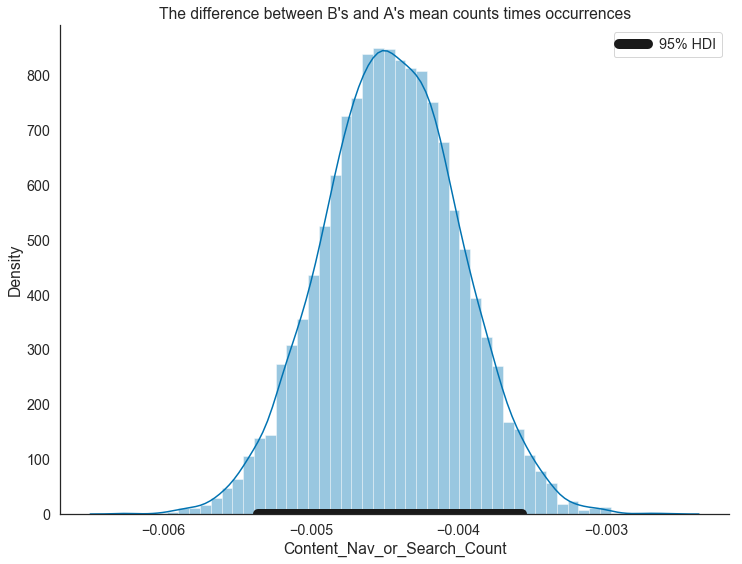

In [126]:
ax = sns.distplot(ypa_diff)
ax.plot([ypa_diff_ci_low, ypa_diff_ci_hi], [0, 0], linewidth=10, c='k', marker='o', 
         label='95% HDI')
ax.set(xlabel='Content_Nav_or_Search_Count', ylabel='Density', 
       title='The difference between B\'s and A\'s mean counts times occurrences')
sns.despine()
legend = plt.legend(frameon=True)
frame = legend.get_frame()
frame.set_facecolor('white')
plt.show();

In [127]:
# We count the number of values greater than 0 and divide by the total number
# of observations
# which returns us the the proportion of values in the distribution that are
# greater than 0, could act a bit like a p-value
(ypa_diff > 0).sum() / ypa_diff.shape[0]

0.0

In [128]:
# We count the number of values less than 0 and divide by the total number
# of observations
# which returns us the the proportion of values in the distribution that are
# less than 0, could act a bit like a p-value
(ypa_diff < 0).sum() / ypa_diff.shape[0]

1.0

In [129]:
(ypa_diff>0).sum()

0

In [130]:
(ypa_diff<0).sum()

10000

## proportion of journeys with a page sequence including content and related links only

There is no statistically significant difference in the proportion of journeys with a page sequence including content and related links only (including loops) between page variant A and page variant B

\begin{equation*}
\frac{\text{total number of journeys that only contain content pages and related links (i.e. no nav pages)}}{\text{total number of journeys}}
\end{equation*}

### Overall

In [131]:
# if (Content_Nav_Search_Event_Sum == 0) that's our success
# Has_No_Nav_Or_Search == 1 is a success
# the problem is symmetrical so doesn't matter too much
sum(df.Has_No_Nav_Or_Search * df.Occurrences) / df.Occurrences.sum()

0.9574360900431184

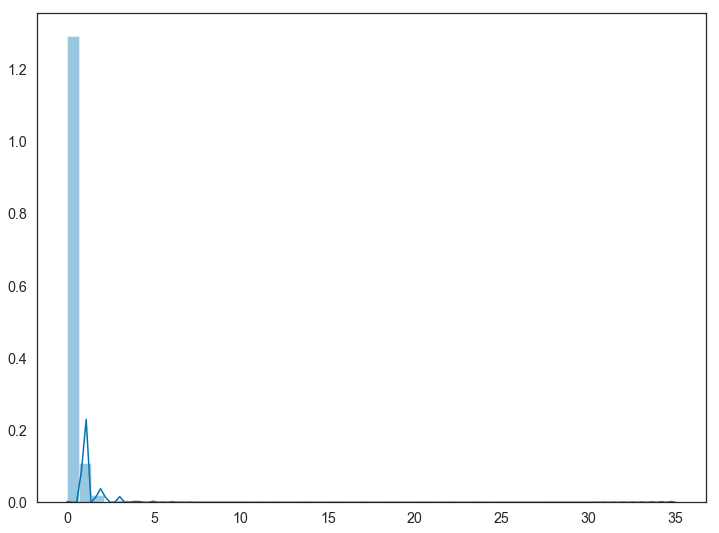

In [132]:
sns.distplot(df.Content_Nav_or_Search_Count.values);

### Frequentist statistics
#### Statistical significance

In [133]:
nav = analysis.z_prop(df, 'Has_No_Nav_Or_Search', VARIANT_DICT)
nav

{'metric_name': 'Has_No_Nav_Or_Search',
 'stats_method': 'z_prop_test',
 'x_ab': 1815025,
 'n_ab': 1895714,
 'p': 0.9574360900431184,
 'x_a': 906209,
 'n_a': 947857,
 'p_a': 0.9560608826014895,
 'x_b': 908816,
 'n_b': 947857,
 'p_b': 0.9588112974847471,
 'test_statistic': -9.379484447255475,
 'p-value': 6.629609416715908e-21}

#### Practical significance - uplift

In [134]:
# Due to multiple testing we used the Bonferroni correction for alpha
ci_low,ci_upp = analysis.zconf_interval_two_samples(nav['x_a'], nav['n_a'],
                                           nav['x_b'], nav['n_b'], alpha = alpha)
diff = 100*(nav['x_b']/nav['n_b']-nav['x_a']/nav['n_a'])
print(' difference in proportions = {0:.2f}%'.format(diff))
print(' 95% Confidence Interval = ( {0:.2f}% , {1:.2f}% )'
      .format(100*ci_low, 100*ci_upp))

 difference in proportions = 0.28%
 95% Confidence Interval = ( 0.20% , 0.35% )


In [135]:
print("There was a {0: .2f}% relative change in the proportion of journeys not using search/nav elements".format(100 * ((nav['p_b']-nav['p_a'])/nav['p_a'])))

There was a  0.29% relative change in the proportion of journeys not using search/nav elements


## Average Journey Length (number of page views)
There is no statistically significant difference in the average page list length of journeys (including loops) between page variant A and page variant B.

In [136]:
length_B = df[df.ABVariant == VARIANT_DICT['INTERVENTION_GROUP']].groupby(
            'Page_List_Length').sum().iloc[:, 0]
lengthB_2 = length_B.reindex(np.arange(1, 501, 1), fill_value=0)

length_A = df[df.ABVariant == VARIANT_DICT['CONTROL_GROUP']].groupby(
            'Page_List_Length').sum().iloc[:, 0]
lengthA_2 = length_A.reindex(np.arange(1, 501, 1), fill_value=0)

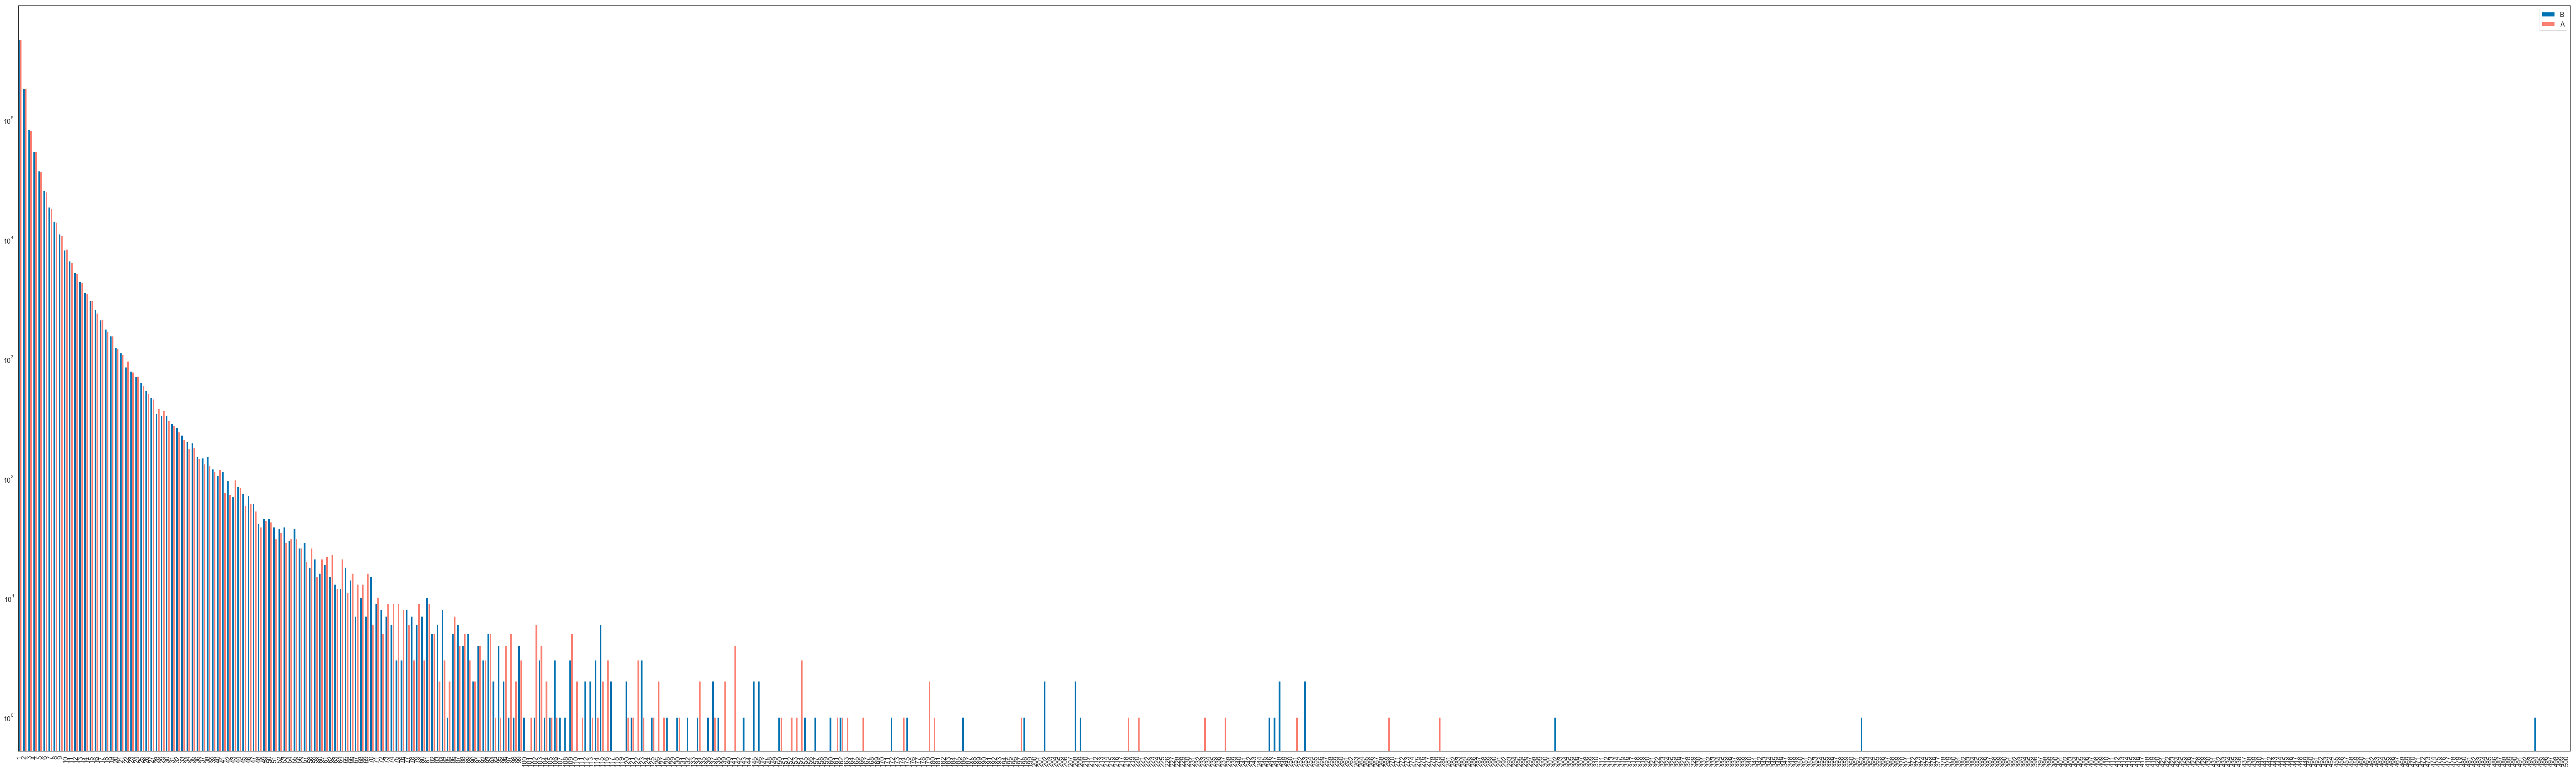

In [137]:
fig, ax = plt.subplots(figsize=(100, 30))

ax.set_yscale('log')
width = 0.4
ax = lengthB_2.plot.bar(label='B', position=1, width=width)
ax = lengthA_2.plot.bar(label='A', color='salmon', position=0, width=width)
plt.xlabel('length', fontsize=1)
legend = plt.legend(frameon=True)
frame = legend.get_frame()
frame.set_facecolor('white')
plt.show();

### Bayesian bootstrap for non-parametric hypotheses

In [138]:
# http://savvastjortjoglou.com/nfl-bayesian-bootstrap.html

In [139]:
# let's use mean journey length (could probably model parametrically but we use it for demonstration here)
# some journeys have length 500 and should probably be removed as they are liekely bots or other weirdness

In [140]:
#exclude journeys of longer than 500 as these could be automated traffic

In [141]:
df_short = df[df['Page_List_Length'] < 500]

In [142]:
print("The mean number of pages in an loved journey is {0:.3f}".format(sum(df.Page_List_Length*df.Occurrences)/df.Occurrences.sum()))

The mean number of pages in an loved journey is 2.948


In [143]:
# for reproducibility, set the seed within this context
a_bootstrap, b_bootstrap = analysis.bayesian_bootstrap_analysis(df, col_name='Page_List_Length', boot_reps=boot_reps, seed = seed, variant_dict=VARIANT_DICT)
a_bootstrap_short, b_bootstrap_short = analysis.bayesian_bootstrap_analysis(df_short, col_name='Page_List_Length', boot_reps=boot_reps, seed = seed, variant_dict=VARIANT_DICT)

In [144]:
np.array(a_bootstrap).mean()

2.9317573438523623

In [145]:
np.array(b_bootstrap).mean()

2.964725520570392

In [146]:
print("There's a relative change in page length of {0:.2f}% from A to B".format((np.array(b_bootstrap).mean()-np.array(a_bootstrap).mean())/np.array(a_bootstrap).mean()*100))

There's a relative change in page length of 1.12% from A to B


In [147]:
print(np.array(a_bootstrap_short).mean())
print(np.array(b_bootstrap_short).mean())

2.9317573438523623
2.964725520570392


In [148]:
# Calculate a 95% HDI
a_ci_low, a_ci_hi = bb.highest_density_interval(a_bootstrap)
print('low ci:', a_ci_low, '\nhigh ci:', a_ci_hi)

low ci: 2.9231442449823506 
high ci: 2.9403731110159375


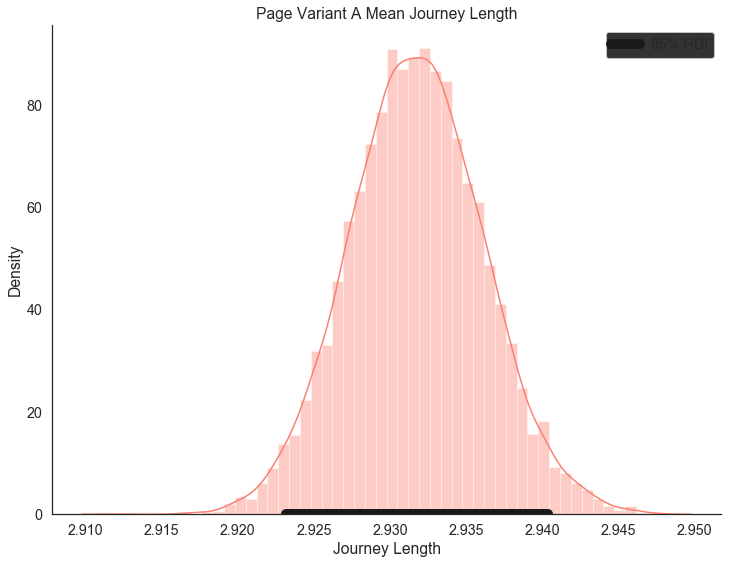

In [149]:
ax = sns.distplot(a_bootstrap, color='salmon')
ax.plot([a_ci_low, a_ci_hi], [0, 0], linewidth=10, c='k', marker='o', 
         label='95% HDI')
ax.set(xlabel='Journey Length', ylabel='Density', title='Page Variant A Mean Journey Length')
sns.despine()
plt.legend();

In [150]:
# Calculate a 95% HDI
b_ci_low, b_ci_hi = bb.highest_density_interval(b_bootstrap)
print('low ci:', b_ci_low, '\nhigh ci:', b_ci_hi)

low ci: 2.955781152370974 
high ci: 2.9736959195222066


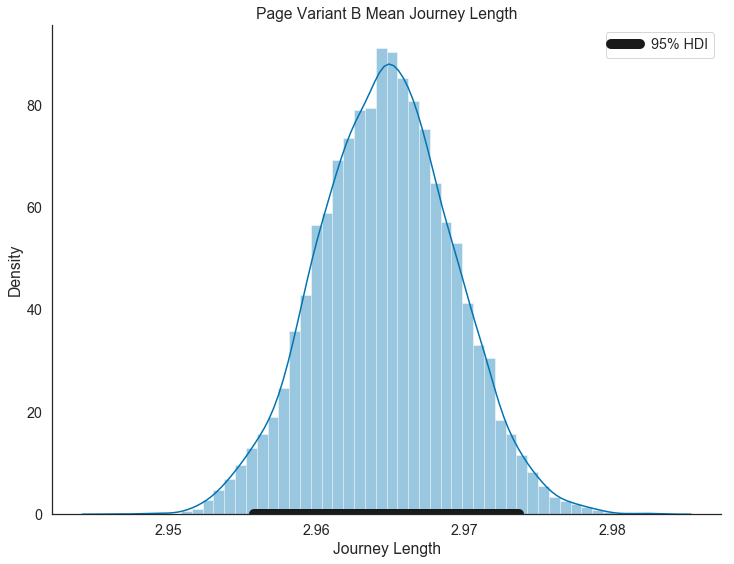

In [151]:
ax = sns.distplot(b_bootstrap)
ax.plot([b_ci_low, b_ci_hi], [0, 0], linewidth=10, c='k', marker='o', 
         label='95% HDI')
ax.set(xlabel='Journey Length', ylabel='Density', title='Page Variant B Mean Journey Length')
sns.despine()
legend = plt.legend(frameon=True)
frame = legend.get_frame()
frame.set_facecolor('white')
plt.show();

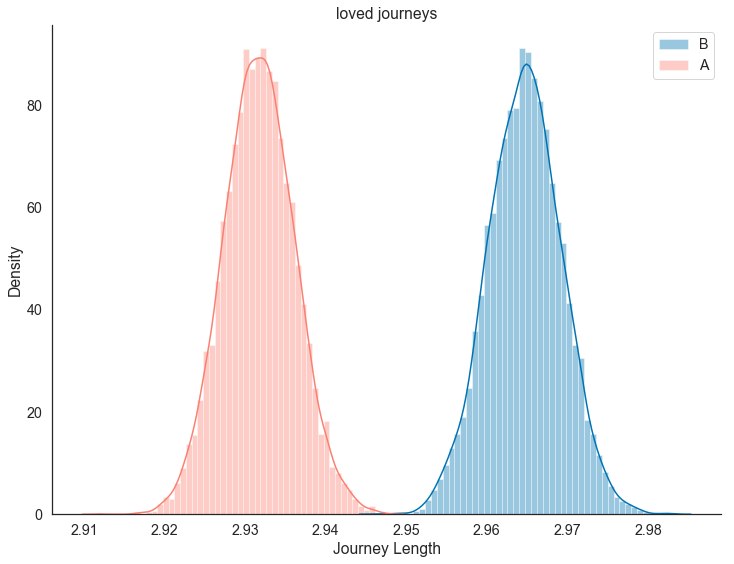

In [152]:
ax = sns.distplot(b_bootstrap, label='B')
ax = sns.distplot(a_bootstrap, label='A', ax=ax, color='salmon')
ax.set(xlabel='Journey Length', ylabel='Density')
sns.despine()
legend = plt.legend(frameon=True)
frame = legend.get_frame()
frame.set_facecolor('white')
plt.title("loved journeys")

plt.savefig('journey_length_loved.png', dpi = 900, bbox_inches = 'tight')

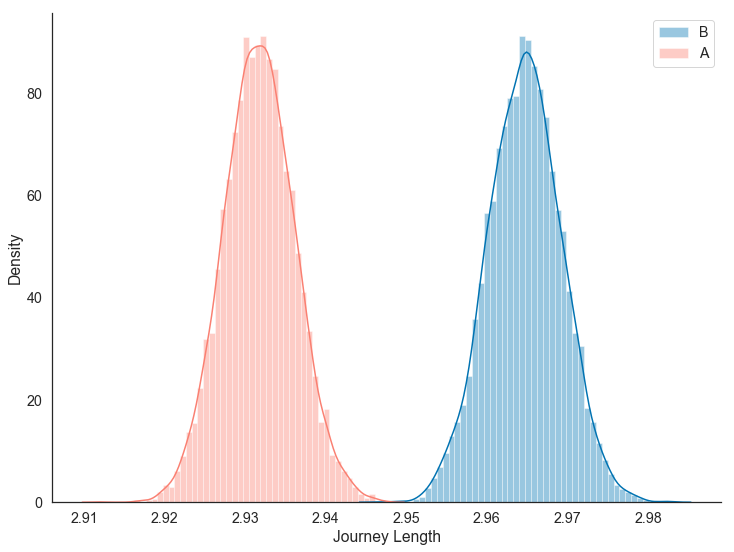

In [153]:
ax = sns.distplot(b_bootstrap_short, label='B')
ax = sns.distplot(a_bootstrap_short, label='A', ax=ax, color='salmon')
ax.set(xlabel='Journey Length', ylabel='Density')
sns.despine()
legend = plt.legend(frameon=True)
frame = legend.get_frame()
frame.set_facecolor('white')
plt.show();

We can also measure the uncertainty in the difference between the Page Variants's Journey Length by subtracting their posteriors.



In [154]:
# calculate the posterior for the difference between A's and B's YPA
ypa_diff = np.array(b_bootstrap) - np.array(a_bootstrap)
# get the hdi
ypa_diff_ci_low, ypa_diff_ci_hi = bb.highest_density_interval(ypa_diff)

In [155]:
# the mean of the posterior
ypa_diff.mean()

0.03296817671803024

In [156]:
print('low ci:', ypa_diff_ci_low, '\nhigh ci:', ypa_diff_ci_hi)


low ci: 0.021046380362182315 
high ci: 0.04576424973256987


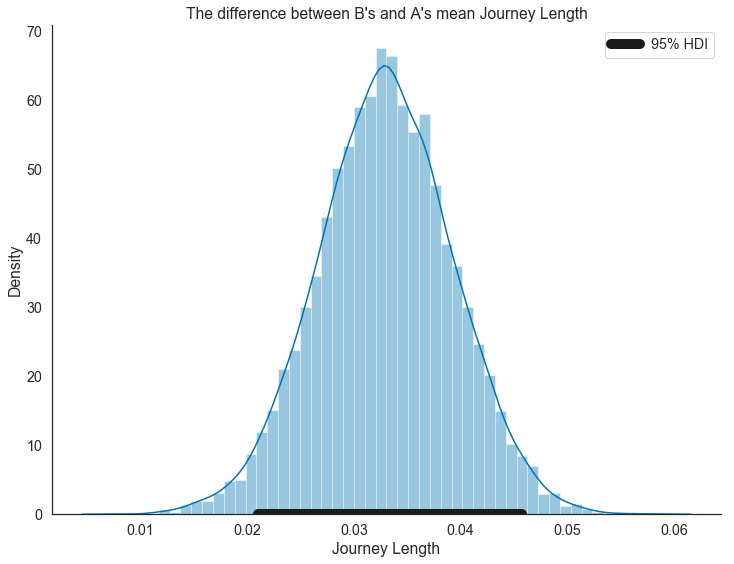

In [157]:
ax = sns.distplot(ypa_diff)
ax.plot([ypa_diff_ci_low, ypa_diff_ci_hi], [0, 0], linewidth=10, c='k', marker='o', 
         label='95% HDI')
ax.set(xlabel='Journey Length', ylabel='Density', 
       title='The difference between B\'s and A\'s mean Journey Length')
sns.despine()
legend = plt.legend(frameon=True)
frame = legend.get_frame()
frame.set_facecolor('white')
plt.show();

We can actually calculate the probability that B's mean Journey Length was greater than A's mean Journey Length by measuring the proportion of values greater than 0 in the above distribution.

In [158]:
# We count the number of values greater than 0 and divide by the total number
# of observations
# which returns us the the proportion of values in the distribution that are
# greater than 0, could act a bit like a p-value
(ypa_diff > 0).sum() / ypa_diff.shape[0]

1.0

In [159]:
# We count the number of values greater than 0 and divide by the total number
# of observations
# which returns us the the proportion of values in the distribution that are
# greater than 0, could act a bit like a p-value
(ypa_diff < 0).sum() / ypa_diff.shape[0]

0.0

# Some other analysis

Some of these results raised more questions, so here's some analysis (with metrics that weren't defined before looking at the other results, so not sure they are statistically valid, but may be interesting nevertheless)

Perhaps journey length is increasing because we're seeing fewer bouncers (journey length = 1) because tey are seeing a relevant lnk on their first page instead of giving up

## Proportion of journeys that are length 1

In [160]:
def is_one(x):
    """Compute whether a journey's length is 1."""
    return x == 1

In [161]:
df['journey_length_1'] = df['Page_List_Length'].progress_apply(is_one)

100%|██████████| 772387/772387 [00:00<00:00, 846978.07it/s]


#### Statistical significance

In [162]:
is_length_1 = analysis.z_prop(df, 'journey_length_1', VARIANT_DICT)
is_length_1

{'metric_name': 'journey_length_1',
 'stats_method': 'z_prop_test',
 'x_ab': 938541,
 'n_ab': 1895714,
 'p': 0.49508575660674553,
 'x_a': 470749,
 'n_a': 947857,
 'p_a': 0.4966455910543468,
 'x_b': 467792,
 'n_b': 947857,
 'p_b': 0.49352592215914426,
 'test_statistic': 4.2955214172322025,
 'p-value': 1.7428320934202147e-05}

In [163]:
is_length_1['p-value'] < alpha

True

#### Practical significance

In [172]:
# Due to multiple testing we used the Bonferroni correction for alpha
ci_low,ci_upp = analysis.zconf_interval_two_samples(is_length_1['x_a'], is_length_1['n_a'],
                                           is_length_1['x_b'], is_length_1['n_b'], alpha = alpha)
print(' difference in proportions = {0:.2f}%'.format(100*(is_length_1['p_b']-is_length_1['p_a'])))
print(' % relative change in proportions = {0:.2f}%'.format(100*((is_length_1['p_b']-is_length_1['p_a'])/is_length_1['p_a'])))
print(' 95% Confidence Interval = ( {0:.2f}% , {1:.2f}% )'
      .format(100*ci_low, 100*ci_upp))

 difference in proportions = -0.31%
 % relative change in proportions = -0.63%
 95% Confidence Interval = ( -0.49% , -0.13% )


## Average journey length where length > 1

In [164]:
# for reproducibility, set the seed within this context
a_bootstrap_gt_1, b_bootstrap_gt_1 = analysis.bayesian_bootstrap_analysis(df[df['journey_length_1'] == False], col_name='Page_List_Length', boot_reps=boot_reps, seed = seed, variant_dict=VARIANT_DICT)
# a_bootstrap_short_gt_1, b_bootstrap_short_gt_1 = analysis.bayesian_bootstrap_analysis(df_short, col_name='Page_List_Length', boot_reps=boot_reps, seed = seed, variant_dict=VARIANT_DICT)

In [165]:
np.array(a_bootstrap_gt_1).mean()

4.837772519978973

In [166]:
np.array(b_bootstrap_gt_1).mean()

4.879134172221864

In [167]:
print("There's a relative change in page length of {0:.2f}% from A to B".format((np.array(b_bootstrap_gt_1).mean()-np.array(a_bootstrap_gt_1).mean())/np.array(a_bootstrap_gt_1).mean()*100))

There's a relative change in page length of 0.85% from A to B


In [168]:
# calculate the posterior for the difference between A's and B's YPA
ypa_diff = np.array(b_bootstrap_gt_1) - np.array(a_bootstrap_gt_1)
# get the hdi
ypa_diff_ci_low, ypa_diff_ci_hi = bb.highest_density_interval(ypa_diff)

In [169]:
print('low ci:', ypa_diff_ci_low, '\nhigh ci:', ypa_diff_ci_hi)


low ci: 0.020260235948303063 
high ci: 0.06327940799389875


In [170]:
# We count the number of values greater than 0 and divide by the total number
# of observations
# which returns us the the proportion of values in the distribution that are
# greater than 0, could act a bit like a p-value
(ypa_diff > 0).sum() / ypa_diff.shape[0]

0.9998

In [171]:
# We count the number of values greater than 0 and divide by the total number
# of observations
# which returns us the the proportion of values in the distribution that are
# greater than 0, could act a bit like a p-value
(ypa_diff < 0).sum() / ypa_diff.shape[0]

0.0002

LLR increases journey lengths across the board